## Datalab 퀵투어

___
## Shell을 통해 datalab 접근

- Cloud Datalab은 GCE VM 위에서 동작하는 Jupyter를 기반으로 만들어진 인터렉티브 도구임
- Datalab 을 조작할때는 `datalab`명령어를 사용
- 아래와 같이 Datalab 인스턴스 생성 가능

```
$ datalab create testdatalab --zone asia-northeast1-b
```

- 기본적으로 `n1-standard-1` 머신을 사용하고, 200gb 전용 디스크, 백업 전용 GCS 버킷, 소스공유 전용 리포지터리 생성

### 유용한 명령어
> `%whos`:      할당된 변수 확인 가능  
> `!git clone`: 노트북 디렉터리 아래에 GitHub 복제  
> `%%bash...`:  bash shell script 실행(Datalab 인스턴스 스타트 시 여러 라이브러리를 설치하는 스크립트)  
> `%%bash echo "pip install --force-reinstall google-cloud-vision==0.27.0" >> /content/datalab/.config/startup.sh`  
> `%%bq query`: 셀 전체를 BigQuery 쿼리 입력으로 식별  
>

### numpy 팁

- numpy에서는 for반복문 사용 대신 **유니버셜함수(각 요소에 연산적용)** 사용을 통해 프로세스를 쉽게 처리 가능

In [1]:
import numpy as np
a = np.array([[1,2,3],[4,5,6]], dtype = np.int32)
a

array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

In [2]:
np.power(a, 2)

array([[ 1,  4,  9],
       [16, 25, 36]], dtype=int32)

- 파이썬 내장함수나 사용자 정의 함수를 **유니버셜함수**로 적용 가능 `np.fompyfunc`
- `np.frompyfunc(<함수>, <입력수>, <출력수>)(<객체>)` 로 사용
- 그 예로 아래 두 함수는 같은 결과값을 반환

In [3]:
%time
for i in a:
    print(str(i))

[1 2 3]
[4 5 6]
CPU times: user 144 µs, sys: 992 µs, total: 1.14 ms
Wall time: 1.59 ms


In [4]:
%time
np.frompyfunc(str, 1, 1)(a)

CPU times: user 36 µs, sys: 6 µs, total: 42 µs
Wall time: 46 µs


array([['1', '2', '3'],
       ['4', '5', '6']], dtype=object)

### pandas 자료구조

|차원|객체|설명|  
|---|---|  
|1차원|Series|행방향만 가지는 데이터|  
|2차원|DataFrame|일반적인 행과열 테이블|  
|3차원|Panel|테이블이 여러 개 중첩되어 있는 구조|  

- DataFrame은 Series의 컨테이너로, Series만도 추출 가능

In [5]:
import pandas as pd
df_a = pd.DataFrame(np.arange(1,7).reshape(2,3), index = ['A', 'B'], columns = list('abc'))
df_a

,a,b,c
A,1,2,3
B,4,5,6


In [6]:
df_a.a

A    1
B    4
Name: a, dtype: int64

___
## BigQuery 연동하기

- ssh 명령으로 호출 table 호출 가능

In [7]:
!bq query "select name, count from kidnames2016.names where state = 'CA' and gender ='F' order by count desc limit 5"

Waiting on bqjob_r6e705a96ceb6085d_0000016650bdca3b_1 ... (0s) Current status: DONE   
+----------+-------+
|   name   | count |
+----------+-------+
| Mia      |  2785 |
| Sophia   |  2747 |
| Emma     |  2592 |
| Olivia   |  2533 |
| Isabella |  2350 |
+----------+-------+


- `!bq query` 대신 `%%bq query`를 사용하면 텍스트 대신 테이블 형태를 반환

In [8]:
%%bq query
select name, count from kidnames2016.names where state = 'CA' and gender ='F' order by count desc limit 5

name,count
Mia,2785
Sophia,2747
Emma,2592
Olivia,2533
Isabella,2350


- `%%bq query` 뒤에 `--name <이름>`으로 쿼리 저장 가능

In [9]:
%%bq query --name popular_names
select name, count from kidnames2016.names where state = 'CA' and gender ='F' order by count desc limit 5

- `%chart`명령어를 쓰면 그래프 생성 가능
- `%chart <그래프 종류> <데이터명> --fields <사용할 데이터행>`
- `%chart --help`로 정보 확인 가능

- column 차트는 일반적인 바차트 반환

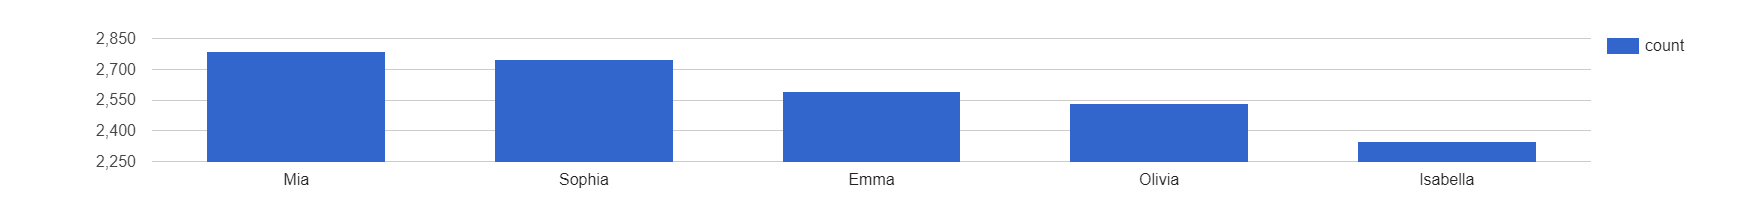

In [10]:
%chart columns --data popular_names --fields name,count

In [32]:
%%bq query --name count_by_state
select state, sum(count) as sum_count from kidnames2016.names group by state order by sum(count) desc

- geo 차트는 다음과 같은 결과 반환

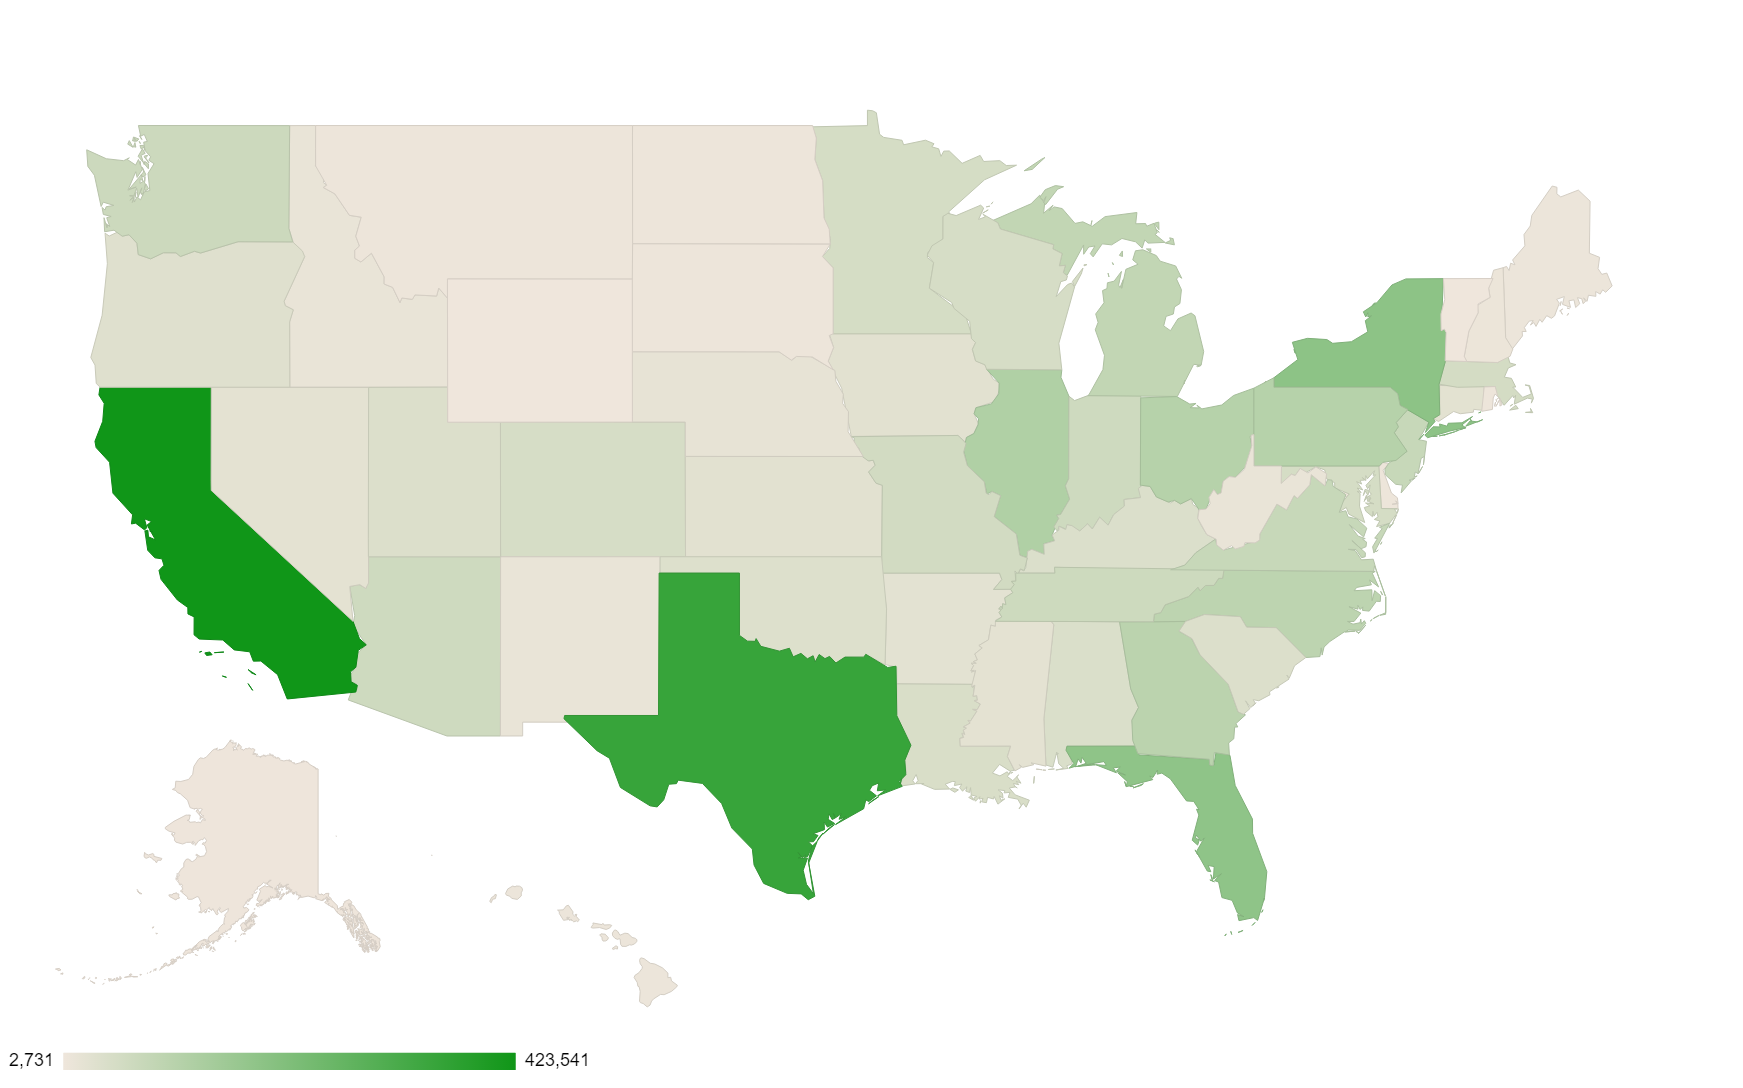

In [33]:
%%chart geo --data count_by_state
{"region": "US", "resolution": "provinces"}

___
### 1) pandas와 연동하기

- BigQuery를 pandas 파일로 연동하는 방법은 2가지가 있음
    1. `pandas.read_gbq(project_id, query)`로 불러들이는 방법
    2. `google.cloud.bigquery`의 `Client.query(query)`로 호출하는 방법
- pandas로 호출하는 방법은 다음과 같음

In [37]:
query = """
select name, count from kidnames2016.names where state = 'CA' and gender ='F' order by count desc limit 5
"""

pd.read_gbq(project_id = 'mlwithgcp', query = query)

Requesting query... ok.
Job ID: b9f031e6-b746-4e71-9f3c-e43e4e718e26
Query running...
Query done.
Processed: 2.1 MB Billed: 10.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 5 rows.

Total time taken 2.05 s.
Finished at 2018-10-07 23:19:44.


,name,count
0,Mia,2785
1,Sophia,2747
2,Emma,2592
3,Olivia,2533
4,Isabella,2350


- pandas의 `to_gbq`메서드로 pd 객체를 BigQuery 테이블로 삽입 가능

In [42]:
pd.read_gbq(project_id = 'mlwithgcp', query = query).to_gbq(project_id = 'mlwithgcp', destination_table = 'kidnames2016.names2')

Requesting query... ok.
Job ID: 79fb71a7-19ba-4157-9e92-a7dae72d5d30
Query running...
Query done.
Cache hit.

Retrieving results...
Got 5 rows.

Total time taken 2.45 s.
Finished at 2018-10-07 23:25:53.



Load is 100.0% Complete




In [45]:
%%bq query
select name, count from kidnames2016.names2

name,count
Mia,2785
Sophia,2747
Emma,2592
Olivia,2533
Isabella,2350


- Google 라이브러리로 호출하는 방법은 다음과 같음

In [38]:
from google.cloud import bigquery
client = bigquery.Client()
client.query(query).to_dataframe()

,name,count
0,Mia,2785
1,Sophia,2747
2,Emma,2592
3,Olivia,2533
4,Isabella,2350


___
### 2) 그래프 그리기

> hayatoy의 git으로부터 데이터 세트 준비  
> `!git clone https://github.com/hayatoy/gcpml-book`

- BigQuery에 신규 데이터셋 생성`!bq mk <데이터셋>` 후 자료를 업로드 `!bq load --autodetect <데이터셋.테이블> <자료위치>`

In [83]:
#!bq mk testdataset
#!git clone https://github.com/hayatoy/gcpml-book
!bq load --autodetect testdataset.tips ./gcpml-book/datasets/tips.csv

Upload complete.
Waiting on bqjob_r7ffdf0302d4f6bfd_0000016650f8ba8b_1 ... (0s) Current status: DONE   


- '1) pandas 연동하기'에서의 내용을 참조, 업로드한 tips 파일로 구성한 `df` 객체 생성

In [4]:
query = "select * from testdataset.tips"
df = pd.read_gbq(project_id='mlwithgcp', query = query)
df.head()

Requesting query... ok.
Job ID: 6b8c81e9-d404-4dc1-a121-b170a51e1dea
Query running...
Query done.
Cache hit.

Retrieving results...
Got 732 rows.

Total time taken 1.58 s.
Finished at 2018-10-08 11:55:42.


,total_bill,tip,gender,smoker,day,time,size
0,5.75,1.00,Female,True,Fri,Dinner,2
1,5.75,1.00,Female,True,Fri,Dinner,2
2,5.75,1.00,Female,True,Fri,Dinner,2
3,22.75,3.25,Female,False,Fri,Dinner,2
4,22.75,3.25,Female,False,Fri,Dinner,2


- 그래프 범위 조정

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 7

- 기본적인 그래프 렌더링 메서드는 `Matplotlib`를 사용
- `<데이터프레임>.plot()` 메서드 만으로 손쉽게 그래프 출력 가능
- `plot(kind='종류')`에 따라 다른 종류의 그래프도 출력 가능

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


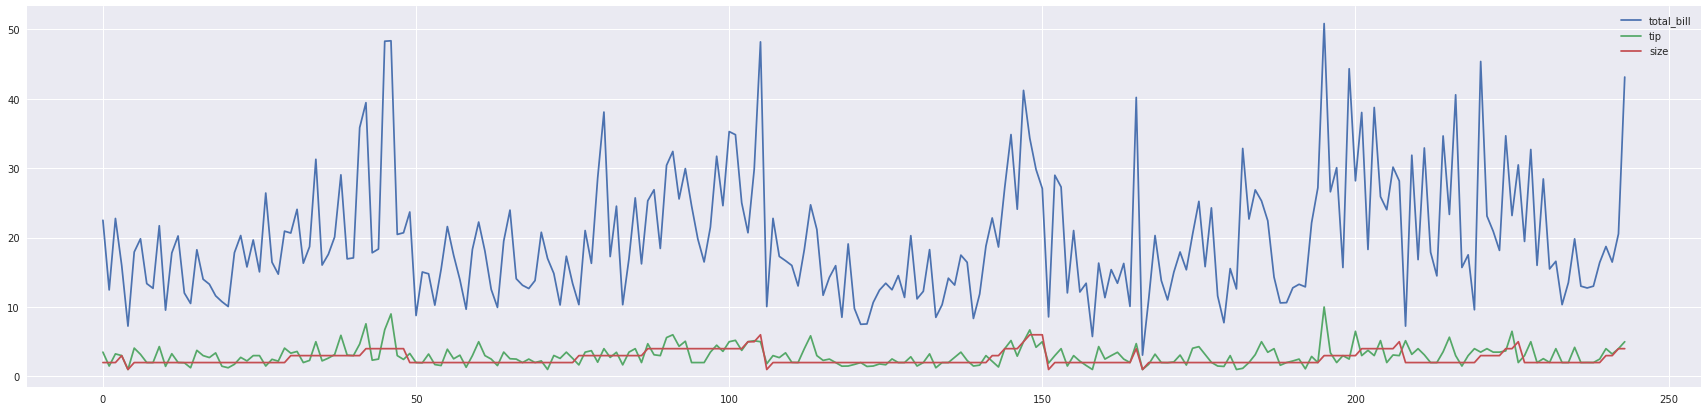

In [73]:
df.plot()

- Matplotlib 외, Seaborn 라이브러리도 유용
- `sns.lmplot()`만으로 손쉽게 단일회귀분석 가능

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/envs/py3env/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


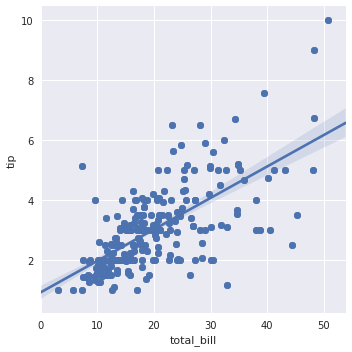

In [5]:
import seaborn as sns
sns.lmplot(data = df, x = 'total_bill', y = 'tip')

- `sns.kdeplot()`은 두 데이터의 밀도 분포를 나타내는 함수
- 이는 아래 plt.scatter의 밀도 분포로 이해 가능

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


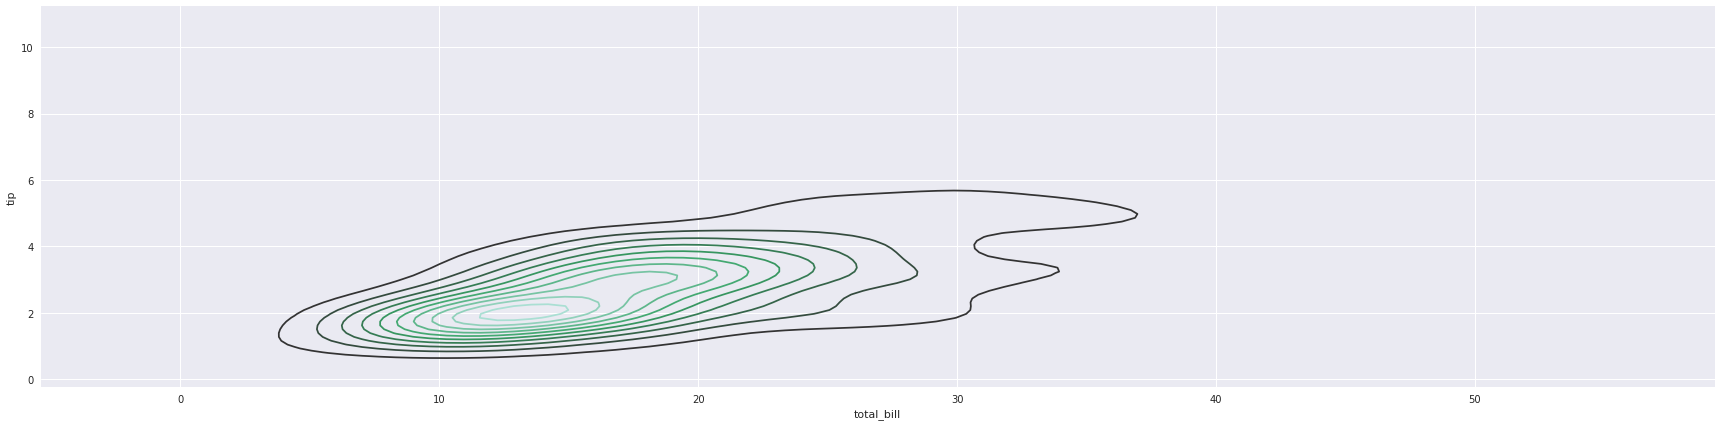

In [77]:
sns.kdeplot(df.total_bill, df.tip)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


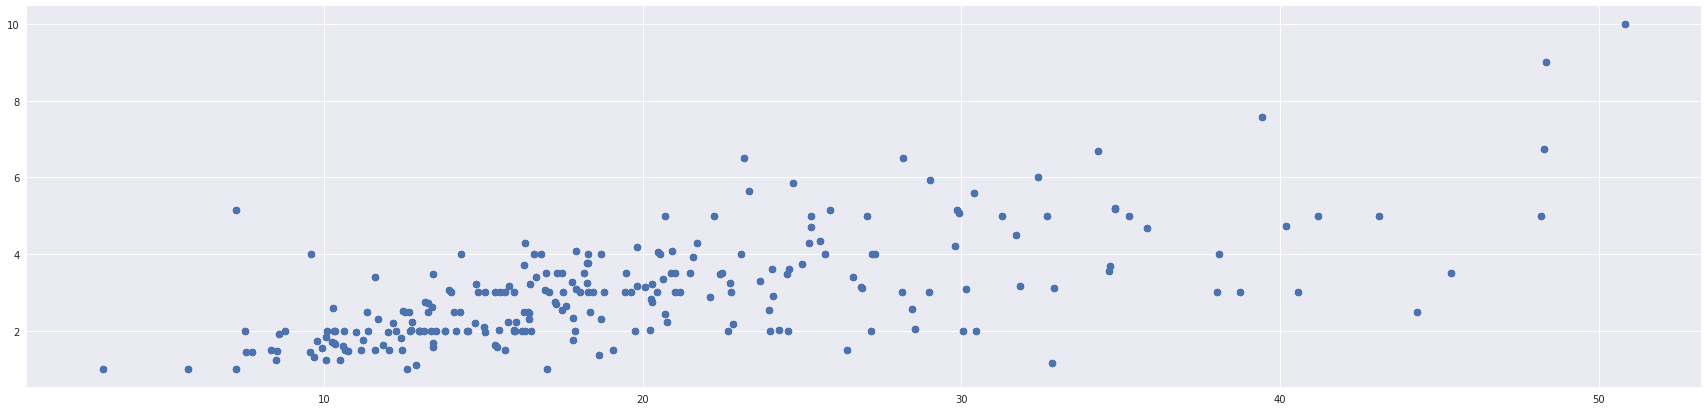

In [13]:
import matplotlib.pylab as plt
plt.scatter(df.total_bill, df.tip)

- 데이터의 분산을 확인하기 위해서는 `sns.distplot()` 사용
- 막대그래프와 kde밀도추정 함수를 반환

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


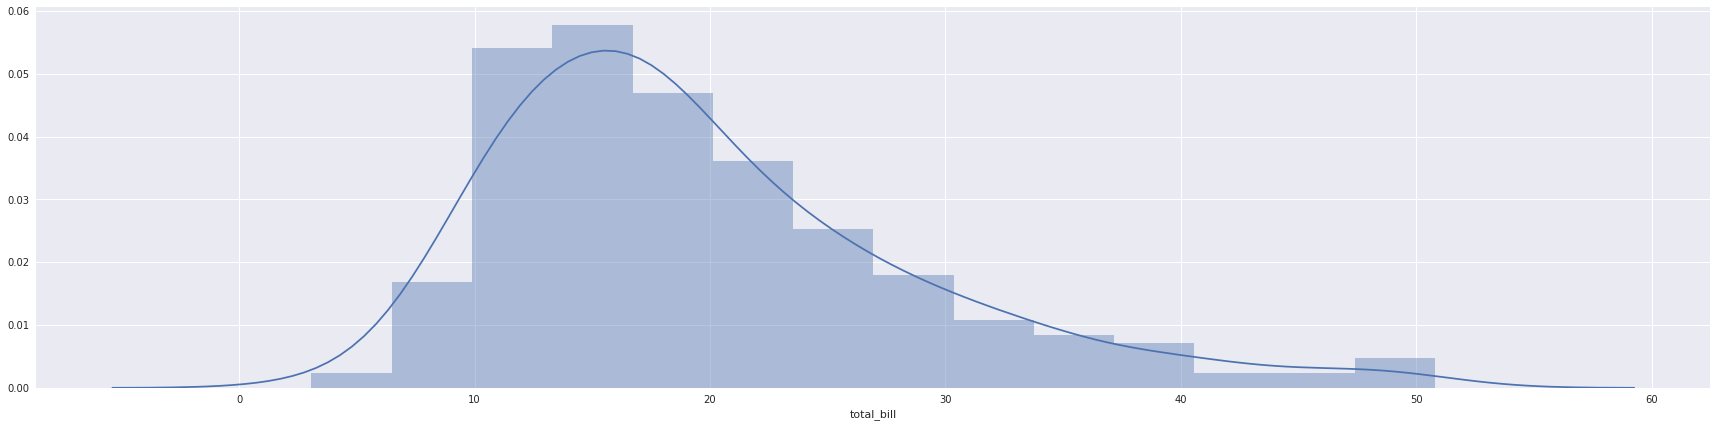

In [78]:
sns.distplot(df.total_bill)

- `<데이터프레임>.corr()`로 변수 간의 상관 관계를 매트릭스로 반환 가능
- `sns.heatmap()` 함수로 상관관계를 쉽게 시각화

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


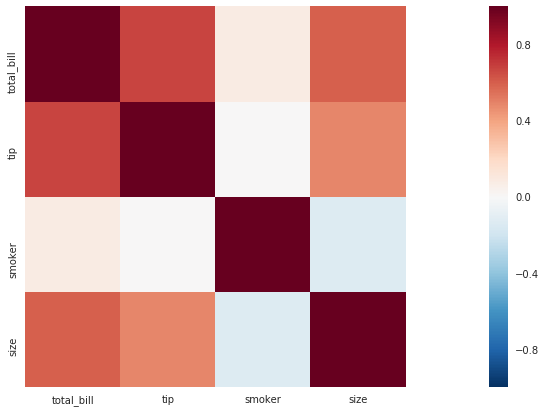

In [15]:
corr = df.corr()
sns.heatmap(corr, square=True)

- 전반적인 변수간의 관계를 확인하고자 할때는 `sns.pairplot()` 함수 사용 가능
- 데이터의 전반적인 **경향**을 설명

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


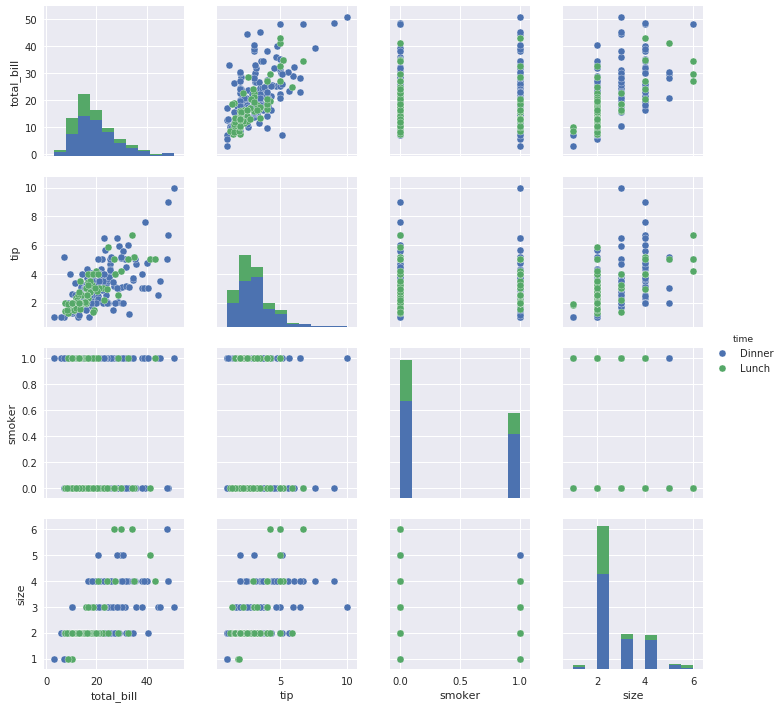

In [81]:
sns.pairplot(df, hue = 'time')